# Which sentiment is reflected by lyrics of english song during political/economical crisis, in countries where that language is primary ? 

## Packages import

In [1]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from nrclex import NRCLex
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random

## Dataset import

In [ ]:
# Approximately 3 to 6 minutes to run
USE_COLS = [
    "lyrics",
    "year",
    "language_cld3",
    "language_ft",
    "tag",
    "artist",
    "title",
    "views"
]

chunks = []
CHUNK_SIZE = 50_000  

for chunk in pd.read_csv(
    "song_lyrics_filtered.csv",
    usecols=USE_COLS,
    chunksize=CHUNK_SIZE,
    low_memory=True,
    engine="python"  
):
    # filtrage immédiat
    chunk = chunk[
        (chunk["language_cld3"] == "en") &
        (chunk["language_ft"] == "en") &
        (chunk["tag"] == "pop")
    ]
    
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

print(df.shape)
df.head()

(1393559, 8)


,title,tag,artist,year,views,lyrics,language_cld3,language_ft
0,Wordy Rappinghood,pop,Tom Tom Club,1981,26499,[Chorus]\nWhat are words worth?\nWhat are word...,en,en
1,Horchata,pop,Vampire Weekend,2009,102550,"[Verse 1]\nIn December, drinking horchata\nI'd...",en,en
2,Heartless,pop,Kanye West,2008,1175109,"[Chorus]\nIn the night, I hear 'em talk\nThe c...",en,en
3,Flashing Lights,pop,Kanye West,2007,1078113,[Intro: Connie Mitchell]\nFlashing lights (Lig...,en,en
4,Baby,pop,Justin Bieber,2010,2232442,[Produced by The-Dream and Tricky Stewart]\n\n...,en,en


In [3]:
# Suppression des colonnes inutiles
df = df.drop(["language_cld3", "language_ft", "tag"], axis=1)

In [4]:
# Enregistrement du df en parquet
df.to_parquet(
    "data/pop_lyrics.parquet",
    index=False
)

In [ ]:
# Chargement du df filtré
df = pd.read_parquet("data/pop_lyrics.parquet")
df.head()

,title,artist,year,views,lyrics
0,Killa Cam,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


## Global descriptive statistics

In [13]:
df.info()
# no missing values 

<class 'pandas.DataFrame'>
Index: 1390653 entries, 0 to 1393558
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   title   1390630 non-null  str  
 1   artist  1390653 non-null  str  
 2   year    1390653 non-null  int64
 3   views   1390653 non-null  int64
 4   lyrics  1390653 non-null  str  
dtypes: int64(2), str(3)
memory usage: 1.6 GB


In [6]:
# Dupes check in df
df[df.duplicated(subset=["title", "artist"], keep=False)] \
  .sort_values(["artist", "title"])

,title,artist,year,views,lyrics
1175764,Celebrate Me Home,CAIN,2020,666,[Verse 1]\nHome for the holidays\nI believe I'...
1255799,Celebrate Me Home,CAIN,2020,32,[Verse 1]\nHome for the holidays\nI believe I'...
989544,HOT,kenzie,2019,32727,[Verse 1]\nShould've listened to my friends\nT...
990182,HOT,kenzie,2019,6911,[Intro]\nWatch out\nWatch out\n\n[Verse 1]\nSh...


In [7]:
# Removing dupes
df = df.drop_duplicates(subset=["title", "artist"], keep="first")
df.shape

(1393557, 5)

In [12]:
# Descriptive statistics for numerics columns
df[["year", "views"]].describe()
# Incoherence in values for year and views (min)

,year,views
count,1.390653e+06,1.390653e+06
mean,2.008798e+03,2.387391e+03
std,1.293257e+01,4.274120e+04
min,1.950000e+03,0.000000e+00
25%,2.003000e+03,3.100000e+01
50%,2.014000e+03,1.070000e+02
75%,2.018000e+03,3.980000e+02
max,2.023000e+03,1.456973e+07


In [14]:
songs_per_year = df["year"].value_counts().sort_index()
songs_per_year.head()

year
1950    210
1951    184
1952    197
1953    232
1954    304
Name: count, dtype: int64

In [10]:
# Filter to keep only years between 1950 and 2023
df = df[(df["year"] >= 1950) & (df["year"] <= 2023)]
df.shape

(1390653, 5)

In [16]:
print(songs_per_year)

year
1950       210
1951       184
1952       197
1953       232
1954       304
         ...  
2019     89177
2020    110099
2021    104796
2022     22709
2023       107
Name: count, Length: 74, dtype: int64


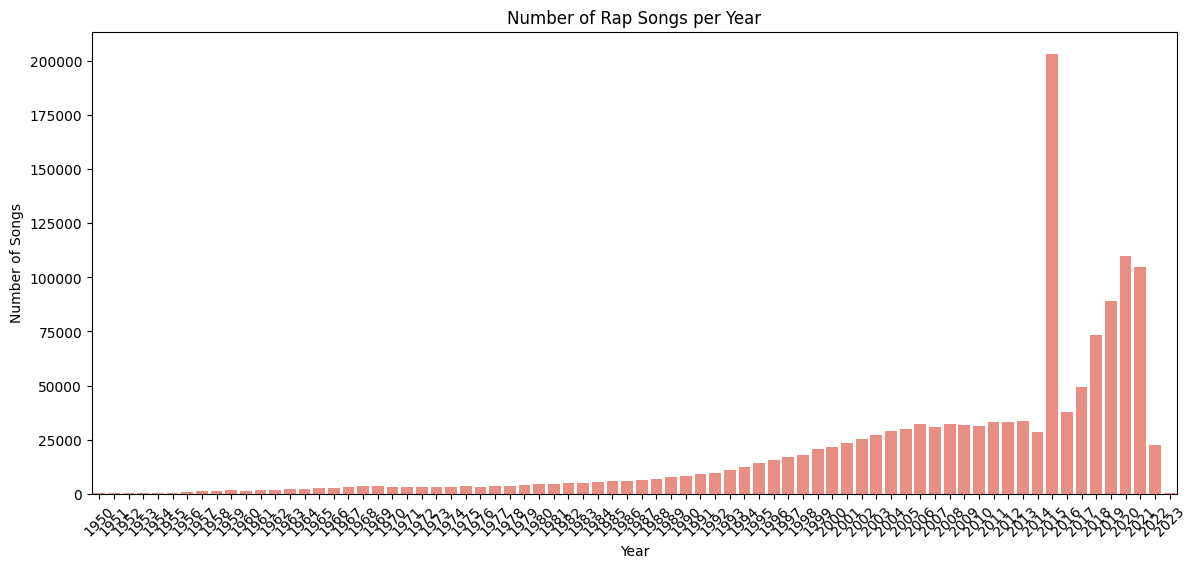

In [17]:
songs_per_year = df["year"].value_counts().sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, color="salmon")
plt.title("Number of Rap Songs per Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()

In [18]:
# Keeping rows only from the year 1980 to 2023
df = df[(df["year"] >= 1980) & (df["year"] <= 2023)]
df["year"].describe()

count    1.326010e+06
mean     2.010722e+03
std      9.669619e+00
min      1.980000e+03
25%      2.005000e+03
50%      2.015000e+03
75%      2.018000e+03
max      2.023000e+03
Name: year, dtype: float64

In [19]:
df["artist"].value_counts().head(10)
# Genius English Translations needs to be removed (the originals songs are not in English)

artist
Genius English Translations    8091
KIDZ BOP Kids                  1181
Madonna                         949
YOUNG DIAMOND                   833
Glee Cast                       706
Pet Shop Boys                   611
Erasure                         590
Depeche Mode                    569
Kylie Minogue                   548
Mariah Carey                    536
Name: count, dtype: int64

In [20]:
# Removing Genius translations
mask_artist = ~df["artist"].str.contains(
    "Genius|Translation|Translations",
    case=False,
    na=False
)

# Removing lyrics too small
#mask_length = df["clean_lyrics"].str.split().str.len() >= 50

# Filter
df = df[mask_artist 
        #& mask_length
        ]

# Check
df["artist"].value_counts().head(10)

artist
KIDZ BOP Kids       1181
Madonna              949
YOUNG DIAMOND        833
Glee Cast            706
Pet Shop Boys        611
Erasure              590
Depeche Mode         569
Kylie Minogue        548
Mariah Carey         536
Hillsong Worship     531
Name: count, dtype: int64

In [21]:
# Quick check of the title and count coherence
df[df["artist"] == "Madonna"]["title"].value_counts().head(20)

title
4 Minutes                           1
Beat Goes On                        1
Like a Virgin / Hollywood Medley    1
Give Me All Your Luvin              1
I Dont Give A                       1
Girl Gone Wild                      1
Love Spent                          1
Im Addicted                         1
Die Another Day                     1
Like a Virgin                       1
Beautiful Stranger                  1
Dress You Up                        1
Vogue                               1
Superstar                           1
Express Yourself                    1
Like a Prayer                       1
Gang Bang                           1
Falling Free                        1
Music                               1
Material Girl                       1
Name: count, dtype: int64

In [22]:
# Shape
df.shape

(1317331, 5)

## Lyrics pre processing

In [ ]:
# Approximately 3 to 4 minutes to run
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

def clean_lyrics(text):
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower()
    tokens = [
        w for w in text.split()
        if w not in STOPWORDS and len(w) > 2
    ]
    return " ".join(tokens)

df["clean_lyrics"] = df["lyrics"].astype(str).apply(clean_lyrics)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# View of clean lyrics
print(df["clean_lyrics"].head())
print(df["clean_lyrics"].loc[1])

0    words worth words worth words words papers wor...
1    december drinking horchata look psychotic bala...
2    night hear talk coldest story ever told somewh...
3    flashing lights lights lights flashing lights ...
4    woah woah woah know love know care shout whene...
Name: clean_lyrics, dtype: str
december drinking horchata look psychotic balaclava winter cold much handle pincher crabs pinch sandals december drinking horchata look glasses aranciata lips teeth ask day went boots fists pound pavement comes feeling thought forgotten chairs sit sidewalks walk remember drinking horchata still enjoy foot masada winter cold much handle pincher crabs pinch sandals comes feeling thought forgotten chairs sit sidewalks walk lost looking back fought december drinking horchata look psychotic balaclava winter cold much handle pincher crabs pinch sandals years hearts start harden palms firs grew garden falling nearing rosebeds roots shooting tool shed lips teeth asked day went shouting cracks 

In [25]:
df.to_parquet(
    "data/pop_lyrics_nlp_clean.parquet",
    index=False
)

In [2]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/pop_lyrics_nlp_clean.parquet"
)

## Sentiment Analysis - Vader

### Top musics (by views of the page)

In [ ]:
# Approximately 1 to 2 minutes to run
MAX_PER_YEAR = 1000  
# years were there are more than 1000 pop songs :  
START_YEAR = 1980
END_YEAR = 2022

df_filtered = df.query(
    "year >= @START_YEAR and year <= @END_YEAR"
)

df_top = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, False])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
)

print("Total songs selected:", len(df_top))
df_top["year"].value_counts().sort_index()

Total songs selected: 43000


year
1980    1000
1981    1000
1982    1000
1983    1000
1984    1000
1985    1000
1986    1000
1987    1000
1988    1000
1989    1000
1990    1000
1991    1000
1992    1000
1993    1000
1994    1000
1995    1000
1996    1000
1997    1000
1998    1000
1999    1000
2000    1000
2001    1000
2002    1000
2003    1000
2004    1000
2005    1000
2006    1000
2007    1000
2008    1000
2009    1000
2010    1000
2011    1000
2012    1000
2013    1000
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
Name: count, dtype: int64

In [ ]:
# Approximately 7 minutes to run
analyzer = SentimentIntensityAnalyzer()

df_top["sentiment"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["compound"])
df_top["sentiment_neg"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neg"])
df_top["sentiment_pos"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["pos"])
df_top["sentiment_neu"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neu"])

In [6]:
df_top.to_parquet(
    "data/pop_lyrics_vader_top.parquet",
    index=False
)

### Less popular musics (by views of the page)

In [28]:
# NEED TO RESTART THE KERNEL (for the memory)
raise RuntimeError(
    "IMPORTANT: Restart the kernel (Kernel → Restart), then Run the rest of the cells.\n"
    "This notebook uses large Arrow-backed DataFrames."
)

RuntimeError: IMPORTANT: Restart the kernel (Kernel → Restart), then Run the rest of the cells.
This notebook uses large Arrow-backed DataFrames.

In [ ]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from nrclex import NRCLex
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random

In [27]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/pop_lyrics_nlp_clean.parquet"
)

ArrowMemoryError: realloc of size 1409286144 failed

In [ ]:
# Approximately 1 to 2 minutes to run
MAX_PER_YEAR = 1000  
START_YEAR = 1980
END_YEAR = 2022

df_filtered = df.query(
    "year >= @START_YEAR and year <= @END_YEAR"
)

df_flop = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, True])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
)

print("Total songs selected:", len(df_flop))
df_flop["year"].value_counts().sort_index()

Total songs selected: 43000


year
1980    1000
1981    1000
1982    1000
1983    1000
1984    1000
1985    1000
1986    1000
1987    1000
1988    1000
1989    1000
1990    1000
1991    1000
1992    1000
1993    1000
1994    1000
1995    1000
1996    1000
1997    1000
1998    1000
1999    1000
2000    1000
2001    1000
2002    1000
2003    1000
2004    1000
2005    1000
2006    1000
2007    1000
2008    1000
2009    1000
2010    1000
2011    1000
2012    1000
2013    1000
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
Name: count, dtype: int64

In [ ]:
# Approximately 5 to 7 minutes to run
analyzer = SentimentIntensityAnalyzer()

df_flop["sentiment"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["compound"])
df_flop["sentiment_neg"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neg"])
df_flop["sentiment_pos"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["pos"])
df_flop["sentiment_neu"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neu"])

In [10]:
df_flop.to_parquet(
    "data/pop_lyrics_vader_flop.parquet",
    index=False
)

In [11]:
# Import of top and flop sentiment vader df
df_top = pd.read_parquet(
    "data/pop_lyrics_vader_top.parquet"
)

df_flop = pd.read_parquet(
    "data/pop_lyrics_vader_flop.parquet"
)

### Vader - Visualisation 

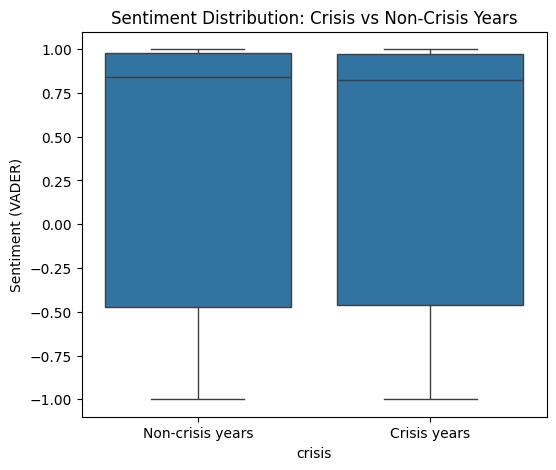

In [12]:
crisis_years = [
    1991,  # Gulf War
    2001,  # 9/11
    2008, 2009,  # Financial crisis
    2020, 2021  # COVID
]

df_flop["crisis"] = df_flop["year"].isin(crisis_years)

plt.figure(figsize=(6,5))
sns.boxplot(
    data=df_flop,
    x="crisis",
    y="sentiment"
)

plt.xticks([0,1], ["Non-crisis years", "Crisis years"])
plt.title("Sentiment Distribution: Crisis vs Non-Crisis Years")
plt.ylabel("Sentiment (VADER)")
plt.show()


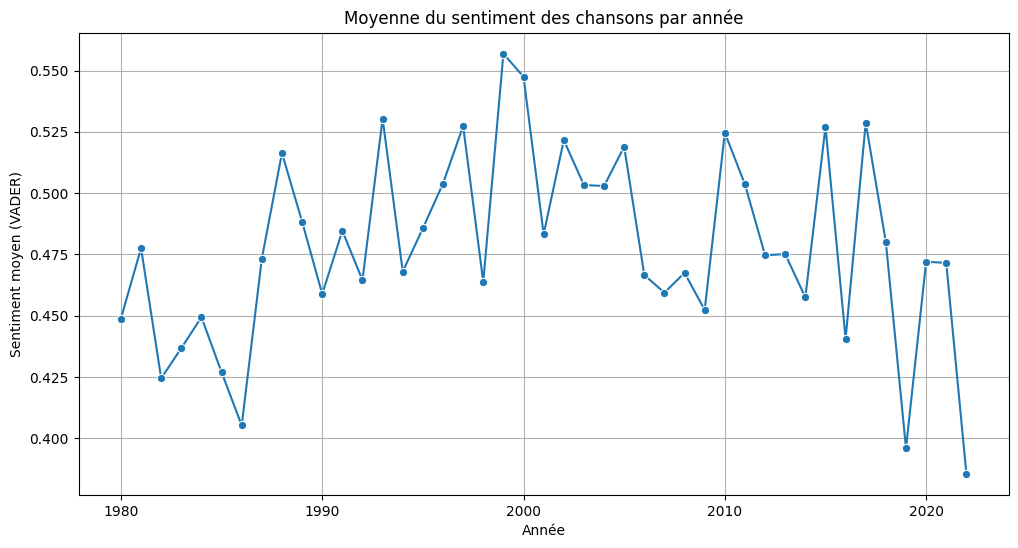

In [ ]:
sentiment_year = df_top.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o")
plt.title("Moyenne du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (VADER)")
plt.grid(True)
plt.show()

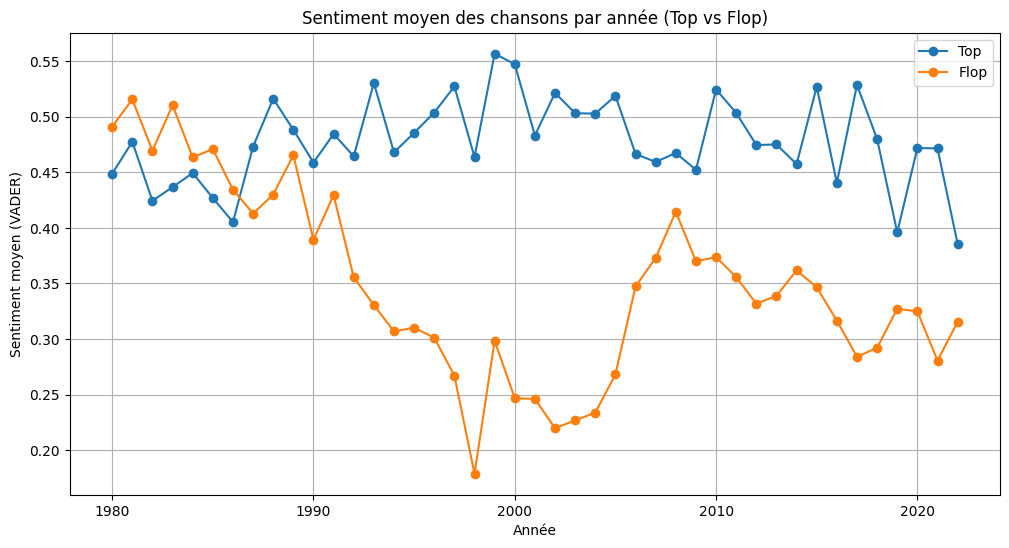

In [13]:
sentiment_top = df_top.groupby("year")["sentiment"].mean()
sentiment_flop = df_flop.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12, 6))
plt.plot(sentiment_top.index, sentiment_top.values, marker="o", label="Top")
plt.plot(sentiment_flop.index, sentiment_flop.values, marker="o", label="Flop")

plt.title("Sentiment moyen des chansons par année (Top vs Flop)")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (VADER)")
plt.legend()
plt.grid(True)
plt.show()

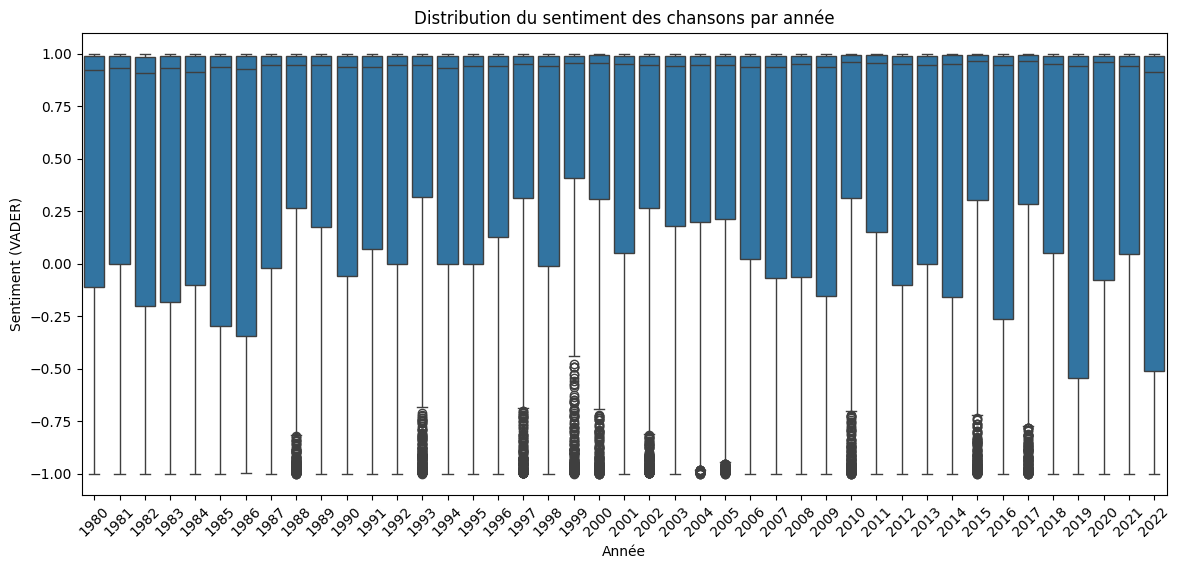

In [10]:
# Boxplots per year
plt.figure(figsize=(14,6))
sns.boxplot(x="year", y="sentiment", data=df_top)
plt.title("Distribution du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment (VADER)")
plt.xticks(rotation=45)
plt.show()

In [19]:
# Event years
us_event_years = {
    1980: "Élection de Ronald Reagan (virage néolibéral)",
    1981: "Crise du sida (reconnaissance publique)",
    1984: "Ère Thatcher / Reagan – dérégulation économique",
    1989: "Chute du mur de Berlin (fin Guerre froide)",
    1991: "Guerre du Golfe",
    1992: "Émeutes de Los Angeles (Rodney King)",
    1994: "Crime Bill & mass incarceration (USA)",
    1997: "Élection de Tony Blair (New Labour)",
    2001: "Attentats du 11 septembre",
    2003: "Guerre en Irak",
    2005: "Ouragan Katrina",
    2008: "Crise financière mondiale / Élection Obama",
    2011: "Mouvement Occupy Wall Street",
    2013: "Début du mouvement Black Lives Matter",
    2014: "Ferguson & violences policières médiatisées",
    2016: "Brexit / Élection de Donald Trump",
    2017: "Mouvement #MeToo",
    2018: "Tensions raciales et polarisation politique",
    2020: "COVID-19 / George Floyd & BLM mondial",
    2021: "Assaut du Capitole (6 janvier)",
    2022: "Guerre en Ukraine / inflation mondiale"
}


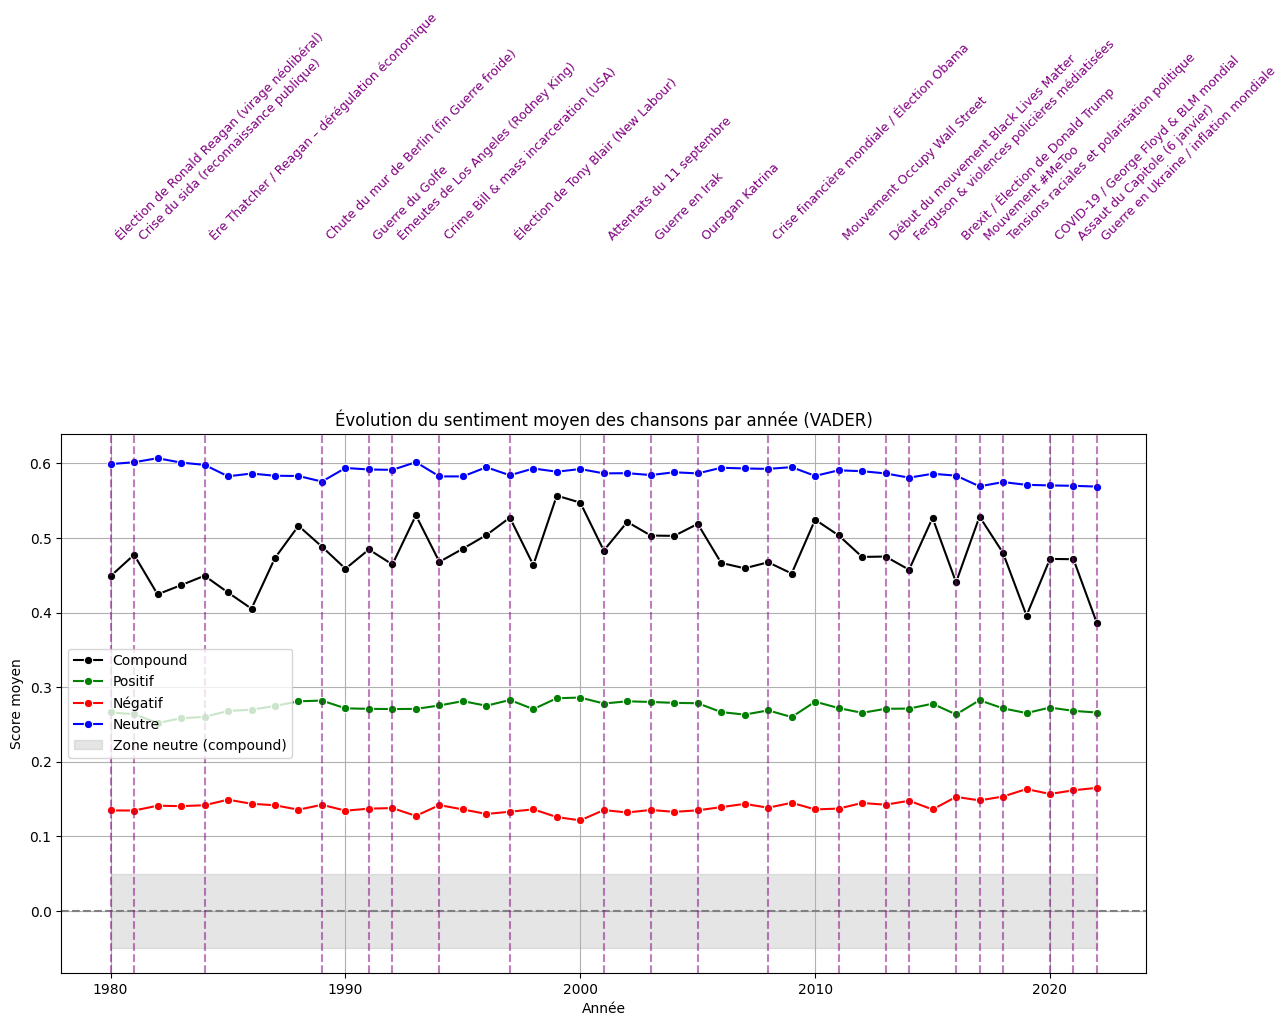

In [20]:
# Scores mean/median per years
sentiment_by_year = df_top.groupby("year")[
    ["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]
].mean()

plt.figure(figsize=(14,7))

sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment"], 
             marker="o", color="black", label="Compound")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_pos"], 
             marker="o", color="green", label="Positif")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_neg"], 
             marker="o", color="red", label="Négatif")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_neu"], 
             marker="o", color="blue", label="Neutre")

plt.axhline(0, color="gray", linestyle="--")
plt.fill_between(sentiment_by_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre (compound)")

for year, event in us_event_years.items():
    if year in sentiment_by_year.index:
        plt.axvline(year, color="purple", linestyle="--", alpha=0.5)
        plt.text(year+0.1, 0.9, event, rotation=45, fontsize=9, color="purple")

plt.title("Évolution du sentiment moyen des chansons par année (VADER)")
plt.xlabel("Année")
plt.ylabel("Score moyen")
plt.legend()
plt.grid(True)
plt.show()

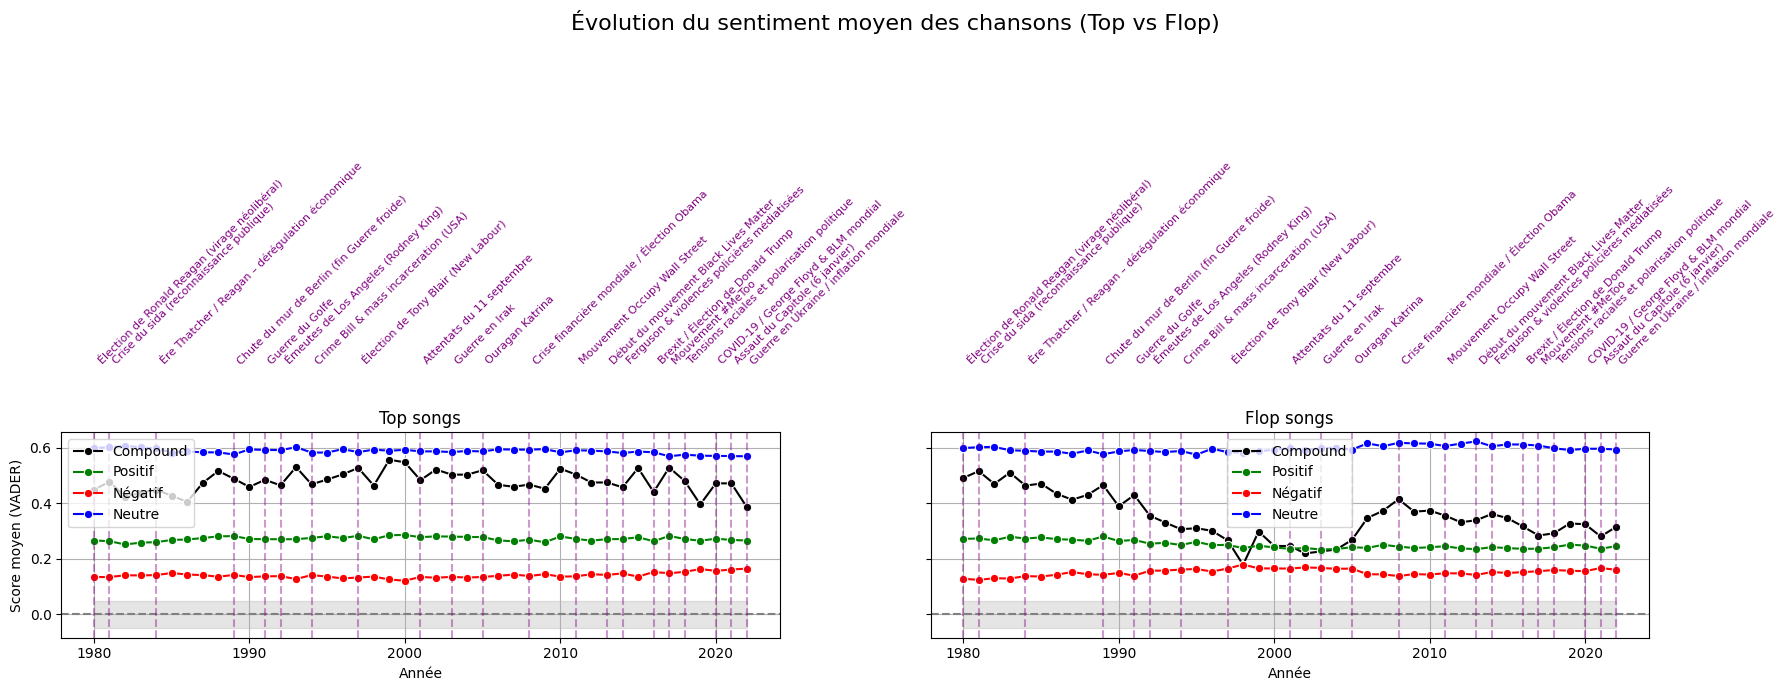

In [21]:
cols = ["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]

sent_top = (
    df_top
    .groupby("year")[cols]
    .mean()
    .reset_index()
    .assign(type="Top")
)

sent_flop = (
    df_flop
    .groupby("year")[cols]
    .mean()
    .reset_index()
    .assign(type="Flop")
)

sentiment_by_year = pd.concat([sent_top, sent_flop], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for ax, label in zip(axes, ["Top", "Flop"]):
    data = sentiment_by_year[sentiment_by_year["type"] == label]

    sns.lineplot(
        data=data,
        x="year",
        y="sentiment",
        marker="o",
        color="black",
        label="Compound",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_pos",
        marker="o",
        color="green",
        label="Positif",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_neg",
        marker="o",
        color="red",
        label="Négatif",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_neu",
        marker="o",
        color="blue",
        label="Neutre",
        ax=ax
    )

    ax.axhline(0, color="gray", linestyle="--")
    ax.fill_between(
        data["year"].unique(),
        -0.05, 0.05,
        color="gray", alpha=0.2
    )

    for year, event in us_event_years.items():
        if year in data["year"].values:
            ax.axvline(year, color="purple", linestyle="--", alpha=0.4)
            ax.text(year + 0.1, 0.9, event, rotation=45,
                    fontsize=8, color="purple")

    ax.set_title(f"{label} songs")
    ax.set_xlabel("Année")
    ax.grid(True)

axes[0].set_ylabel("Score moyen (VADER)")
fig.suptitle("Évolution du sentiment moyen des chansons (Top vs Flop)", fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
# Mean and median of Vader scores per year
sentiment_stats = df_top.groupby("year")[["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]].agg(
    ["mean", "median"]
)

print(sentiment_stats)

     sentiment          sentiment_pos         sentiment_neg          \
          mean   median          mean  median          mean  median   
year                                                                  
1980  0.454058  0.90820      0.262360  0.2400      0.131158  0.1050   
1981  0.450878  0.91460      0.261826  0.2430      0.134822  0.1090   
1982  0.408000  0.90220      0.258808  0.2390      0.144145  0.1180   
1983  0.392086  0.88850      0.256041  0.2340      0.149663  0.1210   
1984  0.372472  0.87575      0.253748  0.2320      0.150115  0.1220   
1985  0.374168  0.88900      0.258785  0.2360      0.153157  0.1270   
1986  0.373505  0.88600      0.260664  0.2360      0.151868  0.1260   
1987  0.397760  0.90220      0.262292  0.2420      0.152006  0.1250   
1988  0.443668  0.91530      0.267451  0.2480      0.144568  0.1210   
1989  0.408708  0.90905      0.268035  0.2490      0.151292  0.1280   
1990  0.425106  0.92010      0.266269  0.2450      0.145507  0.1220   
1991  

## Analysis emotional power - NRC

In [12]:
# Charger le lexique
nrc = pd.read_csv(
    "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    sep="\t",
    names=["word", "emotion", "association"]
)

# On ne garde que les mots associés à une émotion
nrc = nrc[nrc["association"] == 1]

# Créer un dictionnaire {mot: [emotions]}
from collections import defaultdict

nrc_dict = defaultdict(list)
for _, row in nrc.iterrows():
    nrc_dict[row["word"]].append(row["emotion"])

In [13]:
def nrc_score(text, lexicon=nrc_dict):
    tokens = text.lower().split()  # on tokenise simplement par espace
    emotion_counts = Counter()
    
    for token in tokens:
        for emotion in lexicon.get(token, []):
            emotion_counts[emotion] += 1
    
    total = sum(emotion_counts.values())
    if total == 0:
        # Aucun mot associé trouvé, on retourne 0 pour chaque émotion
        return {e: 0 for e in [
            "anger","anticipation","disgust","fear","joy",
            "sadness","surprise","trust","positive","negative"
        ]}
    
    # Normaliser par le total
    return {k: v/total for k, v in emotion_counts.items()}


In [14]:
# Limiter éventuellement à 1000 mots par texte pour accélérer
df_top["nrc_scores"] = df_top["clean_lyrics"].apply(lambda x: nrc_score(x[:1000]))

# Convertir en colonnes séparées
nrc_df = df_top["nrc_scores"].apply(pd.Series)
df_top = pd.concat([df_top, nrc_df], axis=1)

# Exemple : voir les 5 premières lignes
df_top[["anger","joy","sadness","positive","negative"]].head()

,anger,joy,sadness,positive,negative
90,NaN,NaN,0.150000,0.200000,0.150000
434703,0.027397,0.095890,0.027397,0.164384,0.095890
9879,0.057143,0.028571,0.014286,0.042857,0.028571
5934,0.034483,0.137931,0.103448,0.172414,0.172414
26998,NaN,0.177215,0.063291,0.316456,0.037975


In [15]:
# Convertir en colonnes séparées
nrc_df = df_top["nrc_scores"].apply(pd.Series)
df_top = pd.concat([df_top, nrc_df], axis=1)

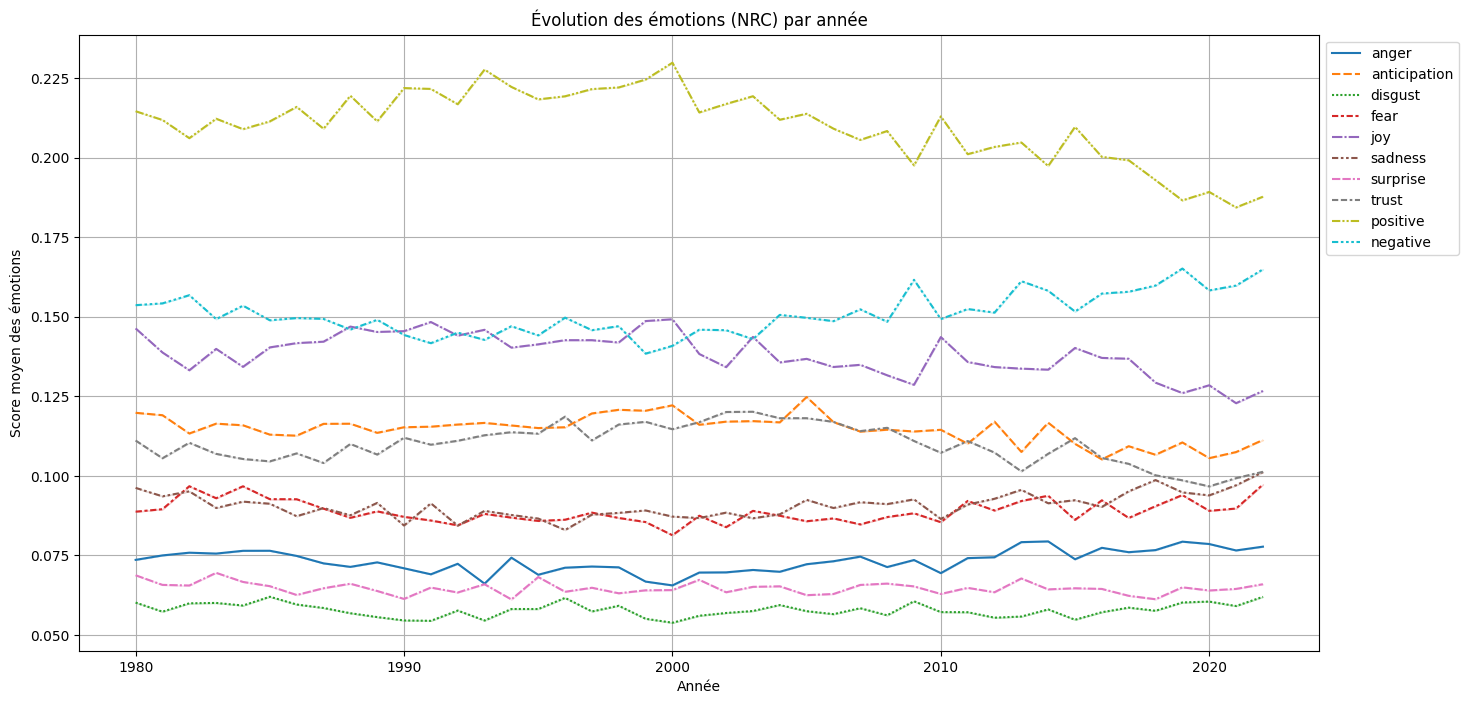

In [16]:
# Moyenne par année
emotion_year = df_top.groupby("year")[
    ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust","positive","negative"]
].mean()

plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year)
plt.title("Évolution des émotions (NRC) par année")
plt.xlabel("Année")
plt.ylabel("Score moyen des émotions")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

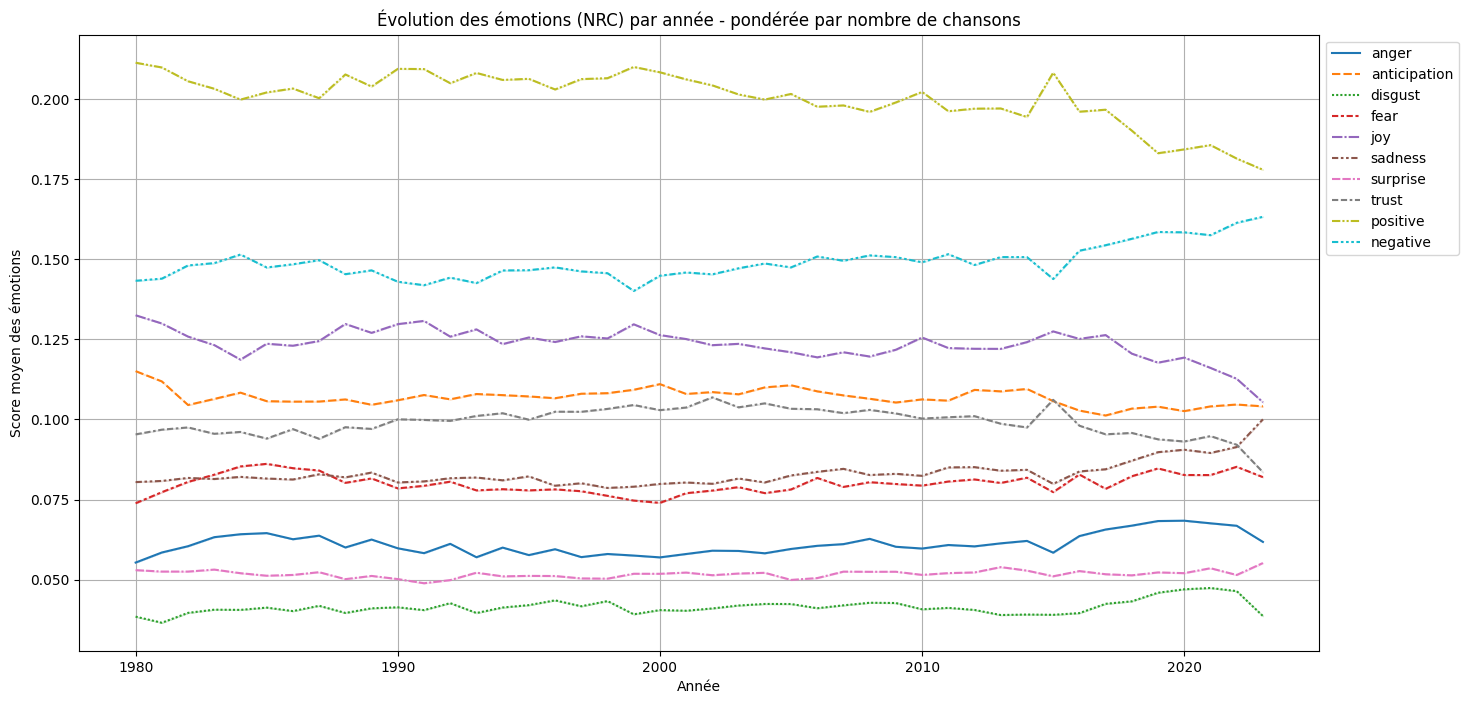

In [44]:
# Colonnes NRC
nrc_cols = ["anger","anticipation","disgust","fear","joy",
            "sadness","surprise","trust","positive","negative"]

# Calcul du nombre de chansons par année
count_per_year = df_top.groupby("year").size()

# Somme des émotions par année
sum_emotions_per_year = df_top.groupby("year")[nrc_cols].sum()

# Moyenne pondérée en divisant par le nombre de chansons par année
emotion_year_p = sum_emotions_per_year.div(count_per_year, axis=0)

# Graphique
plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year_p)
plt.title("Évolution des émotions (NRC) par année - pondérée par nombre de chansons")
plt.xlabel("Année")
plt.ylabel("Score moyen des émotions")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

## LDA

In [45]:
# Configuration du CountVectorizer
cv = CountVectorizer(
    max_df=0.9,           # Ignore les mots dans >90% des documents
    min_df=2,             # Ignore les mots apparaissant <2 fois
    stop_words='english'  # Retire les stop words anglais
)

print("CountVectorizer configuré")
print(f"  - max_df: {cv.max_df} (mots trop fréquents exclus)")
print(f"  - min_df: {cv.min_df} (mots trop rares exclus)")
print(f"  - stop_words: {len(cv.get_stop_words())} mots exclus")

CountVectorizer configuré
  - max_df: 0.9 (mots trop fréquents exclus)
  - min_df: 2 (mots trop rares exclus)
  - stop_words: 318 mots exclus


In [5]:
# Construction de la matrice Document-Terme
dtm = cv.fit_transform(df_top['clean_lyrics'])

print(f"Matrice Document-Terme créée")
print(f"  - Forme: {dtm.shape} (documents x vocabulaire)")
print(f"  - {dtm.shape[0]} documents")
print(f"  - {dtm.shape[1]} mots dans le vocabulaire")
print(f"  - Type: {type(dtm)} (matrice sparse pour économie mémoire)")

Matrice Document-Terme créée
  - Forme: (116331, 110275) (documents x vocabulaire)
  - 116331 documents
  - 110275 mots dans le vocabulaire
  - Type: <class 'scipy.sparse._csr.csr_matrix'> (matrice sparse pour économie mémoire)


### LDA training

In [ ]:
# Initialisation du modèle LDA
LDA = LatentDirichletAllocation(
    n_components=20,      # Nombre de topics à découvrir
    random_state=42      # Pour reproductibilité
)

print("Modèle LDA initialisé avec 20 topics")

Modèle LDA initialisé avec 3 topics


In [7]:
# Entraînement du modèle
# Cela peut prendre du temps avec beaucoup de documents
print("Entraînement du modèle LDA...")
LDA.fit(dtm)
print("✓ Entraînement terminé !")

Entraînement du modèle LDA...


KeyboardInterrupt: 

In [8]:
# Test sur sous-échantillon
dtm_small = dtm[:20000]
LDA.fit(dtm_small)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",50
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [9]:
# Extraction du premier topic
single_topic = LDA.components_[0]
print(f"Topic 0 - Distribution sur {len(single_topic)} mots")

Topic 0 - Distribution sur 110275 mots


In [10]:
top_ten_words = single_topic.argsort()[-10:]

In [11]:
# Conversion des indices en mots
print("\nTop 10 mots du Topic 0:")
for index in top_ten_words:
    word = cv.get_feature_names_out()[index]
    prob = single_topic[index]
    print(f"  - {word:<20} (probabilité: {prob:.4f})")


Top 10 mots du Topic 0:
  - master               (probabilité: 626.9376)
  - funky                (probabilité: 631.2165)
  - rhymes               (probabilité: 642.6177)
  - know                 (probabilité: 665.8548)
  - beat                 (probabilité: 776.6686)
  - bass                 (probabilité: 906.0501)
  - fresh                (probabilité: 1029.3329)
  - cause                (probabilité: 1250.5149)
  - rhyme                (probabilité: 1417.4014)
  - boogie               (probabilité: 1492.8365)


In [ ]:
# Boucle sur tous les topics
print("=" * 70)
print("TOPICS DÉCOUVERTS PAR LDA")
print("=" * 70)

for i, topic in enumerate(LDA.components_):
    print(f"\nTOPIC #{i}")
    print("-" * 70)
    top_words = [cv.get_feature_names_out()[idx] for idx in topic.argsort()[-15:]]
    print("Top 15 mots:", ', '.join(top_words))

print("\n" + "=" * 70)

TOPICS DÉCOUVERTS PAR LDA

TOPIC #0
----------------------------------------------------------------------
Top 15 mots: way, jam, like, run, posse, master, funky, rhymes, know, beat, bass, fresh, cause, rhyme, boogie

→ Interprétation suggérée: [À compléter manuellement]

TOPIC #1
----------------------------------------------------------------------
Top 15 mots: yah, man, cause, rock, come, soul, hah, wreck, like, yeah, got, know, hop, hip, check

→ Interprétation suggérée: [À compléter manuellement]

TOPIC #2
----------------------------------------------------------------------
Top 15 mots: hell, train, got, ways, choo, bum, million, bout, triple, dollar, woo, cash, livin, ride, money

→ Interprétation suggérée: [À compléter manuellement]

TOPIC #3
----------------------------------------------------------------------
Top 15 mots: cause, make, wonder, better, like, respect, friends, think, dead, know, life, gangsta, got, ghetto, world

→ Interprétation suggérée: [À compléter manuell